# Use case 0: Playing around with ShowerModel

In [1]:
import showermodel as sm
import numpy as np
import matplotlib.pyplot as plt

### Showers

Let's generate a 1 TeV gamma-induced shower with 20 degrees zenith angle impacting 0.1 km east and 0.2 km north from some ground-based telescope located at 2.2 km above sea level.

In [2]:
shower = sm.Shower(1.e6, theta=20., az=45., x0=0.1, y0=0.2, h0=2.2)

`Shower` contains information on the shower track geometry, energy deposit profile and both Cherenkov and fluorescence light production.

In [3]:
#shower.track
shower.profile
#shower.cherenkov
#shower.fluorescence

,X,s,dX,E_dep,N_ch
0,833.809519,1.639942e+00,20.886275,1745.333331,31.730952
1,813.133112,1.621252e+00,20.467949,2162.692406,40.159662
2,792.870827,1.602432e+00,20.058002,2655.502849,50.365789
3,773.014371,1.583483e+00,19.656266,3231.401894,62.600293
4,753.555613,1.564409e+00,19.262576,3897.468497,77.120065
...,...,...,...,...,...
545,0.000096,4.178872e-07,0.000021,0.000009,0.090310
546,0.000075,3.250234e-07,0.000021,0.000009,0.090309
547,0.000054,2.321596e-07,0.000021,0.000009,0.090308
548,0.000032,1.392957e-07,0.000021,0.000009,0.090307


This object also has some atributes and methods to make calculations and plot data.

Depth of maximum (g/cm^2): 345.753
Height of shower maximum (km): 6.61


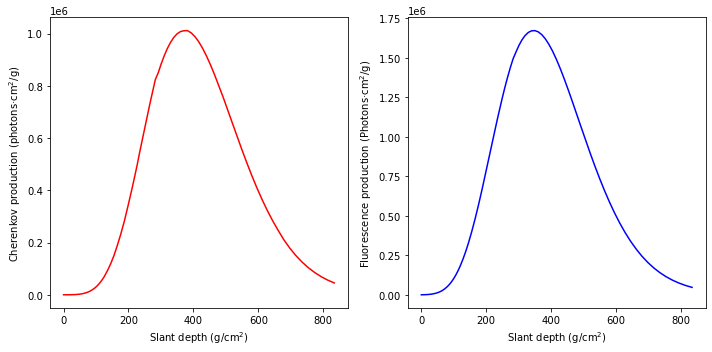

In [4]:
X_max = shower.X_max
x, y, z = shower.track.X_to_xyz(X_max)
print("Depth of maximum (g/cm^2):", np.around(X_max, 3))
print("Height of shower maximum (km):", np.around(z, 3))
shower.show_light_production();

For example, you may be interested in evaluating the photon density on horizontal planes at different heights (0, 5 and 10 km above ground level). A full MC simulation would take a long time, but `ShowerModel` allows you to do this calculation in a relatively short time.

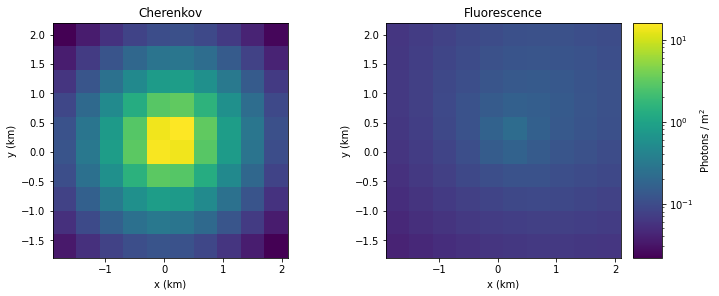

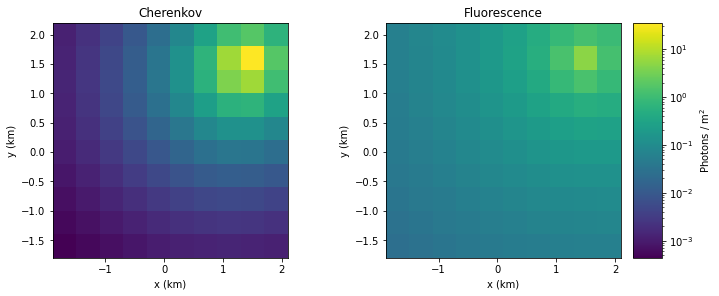

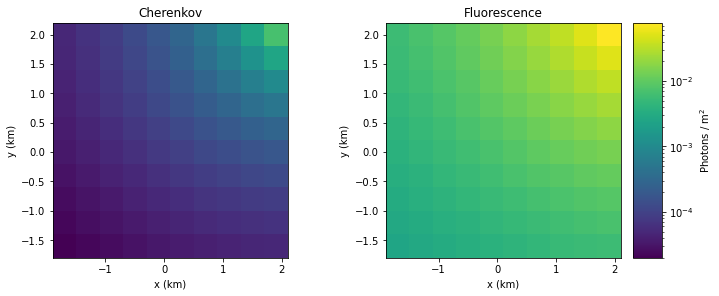

In [5]:
for z in [0., 5., 10.]:
    shower.show_distribution(x_c=shower.x0, y_c=shower.y0, z_c=z, size_x=4., size_y=4., N_x=10, N_y=10);

### Observatory events

Now, we can generate an observatory consisting in a 500 m radius circular array of 25 IACTs pointing at the shower arrival direction. There exists a function to do that with default telescope parameters.

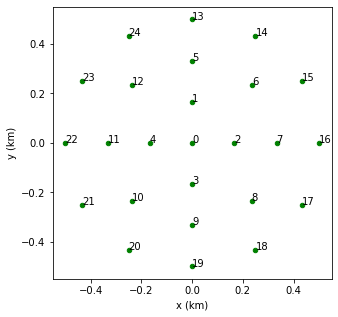

In [6]:
observatory = sm.Array25(R=0.5, theta=20., az=45.)
observatory.show();

Some characteristics of the default IACT.

In [7]:
print("Angular aperture (deg):", observatory[0].apert)
print("Number of pixels:", observatory[0].N_pix)
print("Collection area (m^2):", observatory[0].area)
print("Position of telescope #8 (km):", np.around([observatory[8].x, observatory[8].y], 3))

Angular aperture (deg): 8.0
Number of pixels: 1800
Collection area (m^2): 113.097
Position of telescope #8 (km): [ 0.236 -0.236]


An `Event` object can be generated from the above-defined `Shower` and `Observatory` objects.

In [8]:
event = sm.Event(shower, observatory)

It contains the shower track projection and signal at each telescope.

In [9]:
event.projections[8]
#event.signals[8]

,distance,alt,az,theta,phi,beta,time,FoV
0,0.485012,11.967679,346.617250,68.268420,16.959319,68.268420,1.015937,False
1,0.598276,30.285485,353.548306,48.856659,16.959319,48.856659,0.679743,False
2,0.756485,41.661785,359.362985,36.553427,16.959319,36.553427,0.493467,False
3,0.937146,48.696291,4.216889,28.734994,16.959319,28.734994,0.382082,False
4,1.129536,53.258711,8.275287,23.507737,16.959319,23.507737,0.309824,False
...,...,...,...,...,...,...,...,...
545,116.839319,69.901311,44.423409,0.220937,16.959319,0.220937,0.000024,True
546,117.053371,69.901493,44.424458,0.220533,16.959319,0.220533,0.000018,True
547,117.267422,69.901675,44.425504,0.220131,16.959319,0.220131,0.000013,True
548,117.481474,69.901856,44.426545,0.219730,16.959319,0.219730,0.000008,True


There are methods to visualize the event geometry and time evolution of signals.

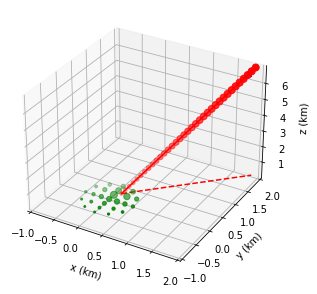

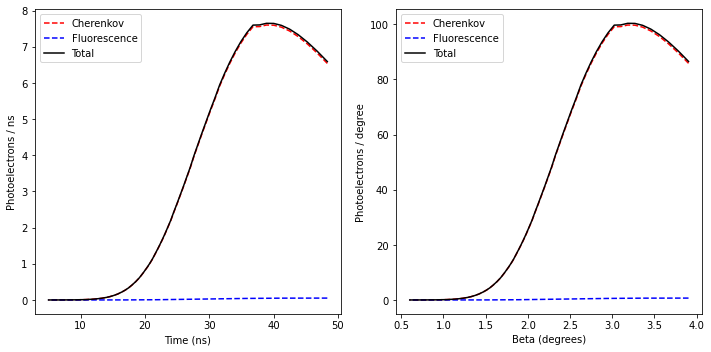

In [10]:
event.show_geometry3D(x_min=-1., x_max=2., y_min=-1., y_max=2.);
event.signals[8].show();

For example, you may want to obtain the number of telescopes having an integrated signal greater than 100 photoelectrons as a function shower energy. Below, observatory events are generated for 10 showers with energies from 50 GeV to 5 PeV. The trigger condition is evaluated for each telescope of the observatory (25 telescopes). Calculations may take a while.

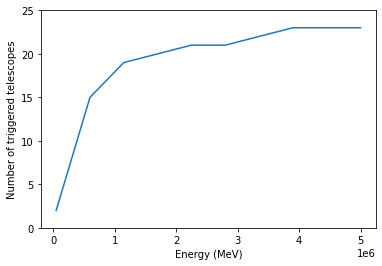

In [11]:
energy = np.linspace(50.e3, 50.e5, 10)
trig_tel = np.zeros_like(energy)
for (i, E) in enumerate(energy):
    event = sm.Event(shower.copy(E=E), observatory)
    Npe_sum = np.array([event.signals[tel].Npe_total_sum for tel in range(25)])
    trig_tel[i] = len(Npe_sum[Npe_sum>100])
plt.plot(energy, trig_tel);
plt.xlabel("Energy (MeV)");
plt.ylabel("Number of triggered telescopes");
plt.ylim(0, 25);

### Camera images

Camera images (actually, image sequences) are generated assuming a Nishimura-Kamata-Greisen lateral distribution of electrons in the shower. A night sky background of 40 MHz/m$^2$/deg$^2$ is assumed by default, but this parameter can be changed. The integration time (in $\mu$s) per camera frame can be set too.

In the example below, the integrated image is shown for one of the telescopes (`tel_index=12`) of the observatory. The camera has 1800 pixels (default). Then, the image sequence (17 frames) is shown.

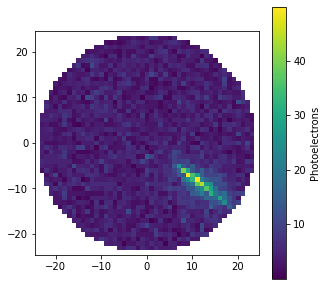

In [12]:
image = sm.Image(event.signals[12], int_time=0.002)
image.show();

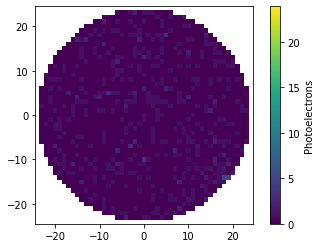

In [13]:
image.animate()

`Event` includes a method to show the images of all the telescopes in the same figure. Again, calculations may take a while, because there are 25 telescopes with 1800 pixels each, and each image is the sum of several frames.

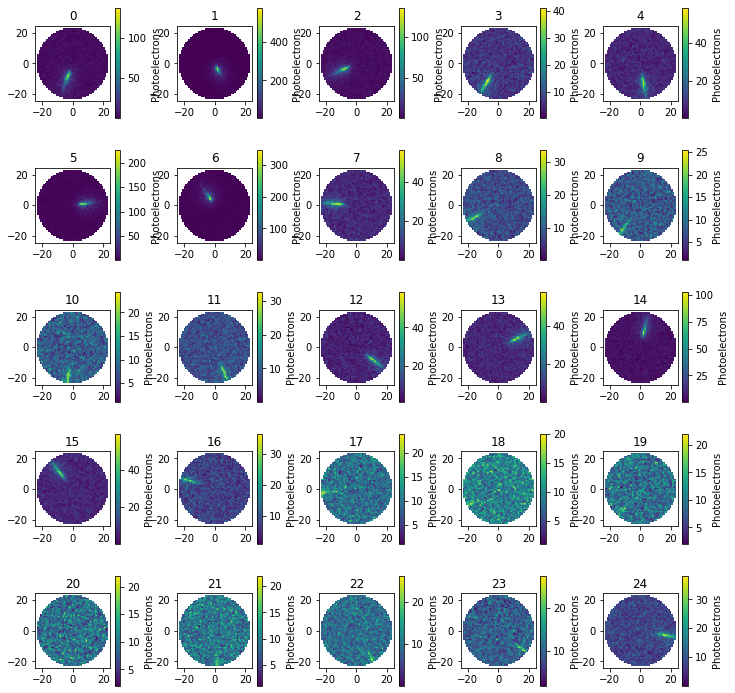

In [14]:
event.make_images(NSB=50.)
event.show_images();